In [1]:
import numpy as np 
import pandas as pd 

In [2]:
df = pd.read_csv('rset/rset.csv')

In [3]:
#rename 'balanced' column to 'balance'
df = df.rename(columns={'balanced':'balance'})

In [4]:
df['proportion_nan'] = df['n_nan_preds'] / df['test_set_size']

In [5]:
df.head()

,dataset,base_tree,NaN_condition,balance,prebin_missingness,rset_size,acc_complete_train,acc_complete_test,avg_sparsity_complete,miss_prob,test_set_size,n_nan_preds,acc_incomplete_when_not_nan,acc_complete_on_points_where_incomplete_not_nan,avg_sparsity_incomplete,acc_when_nan_if_0_impute,proportion_nan
0,compas_complete.csv,rset,path-based,True,False,910,0.679445,0.648163,6.0,0.1,1279,0,0.643471,0.648163,5.934324,NaN,0.000000
1,compas_complete.csv,rset,path-based,True,False,910,0.679445,0.648163,6.0,0.2,1279,1,0.643192,0.647887,5.858372,0.000000,0.000782
2,compas_complete.csv,rset,path-based,True,False,910,0.679445,0.648163,6.0,0.3,1279,9,0.648819,0.650394,5.782677,0.444444,0.007037
3,compas_complete.csv,rset,path-based,True,False,910,0.679445,0.648163,6.0,0.4,1279,23,0.656847,0.650478,5.688694,0.695652,0.017983
4,compas_complete.csv,rset,path-based,True,False,910,0.679445,0.648163,6.0,0.5,1279,54,0.646531,0.647347,5.541224,0.555556,0.042220


In [6]:
groups = df.groupby(['base_tree', 'dataset', 'NaN_condition', 'miss_prob', 'balance', 'prebin_missingness'])

In [7]:
to_plot = groups.agg(['mean', 'std'])

In [8]:
import matplotlib.pyplot as plt

In [9]:
miss_probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
epsilon = 0.02
lam = 0.01
def plot_dataset_obj(dataset='compas.csv', base_tree = 'rset', balance=True, prebin = False): 
    ys = []
    yerrs = []
    xs = []
    xerrs = []
    for miss_prob in miss_probs: 
        row = to_plot.loc[(base_tree, dataset, 'path-based', miss_prob, balance, prebin), :]
        ys.append(1-row['acc_incomplete_when_not_nan']['mean'] + lam * row['avg_sparsity_incomplete']['mean'])
        yerrs.append(row['acc_incomplete_when_not_nan']['std']/np.sqrt(5))
        xs.append(1 - row['proportion_nan']['mean'])
        xerrs.append(row['proportion_nan']['std']/np.sqrt(5))
    plt.errorbar(miss_probs, ys, 
                yerr=yerrs, label=f'Rset model')

    # plt.hlines(row['acc_complete_test']['mean'], 0, 1, linestyles='dashed', colors='gray', label='Complete Test Accuracy on all data')
    # plt.errorbar([0, 1], [row['acc_complete_test']['mean']]*2, yerr = row['acc_complete_test']['std']/np.sqrt(5), color='gray')
    # plt.fill_between([0, 1], [row['acc_complete_test']['mean'] - row['acc_complete_test']['std']/np.sqrt(5)]*2, [row['acc_complete_test']['mean'] + row['acc_complete_test']['std']/np.sqrt(5)]*2, color='gray', alpha=0.5)
    # plt.errorbar([0, 1], [row['acc_complete_test']['mean'] - epsilon]*2, yerr = row['acc_complete_test']['std']/np.sqrt(5), color='gray', linestyle='dashed', label='Epsilon below accuracy on complete data')
    plt.errorbar([0, 1], [1-row['acc_complete_test']['mean'] + epsilon + lam * row['avg_sparsity_complete']['mean']]*2, color='gray', linestyle='dashed', label=f"Epsilon above best tree's objective \n on complete data")
    # plt.fill_between([0, 1], [row['acc_complete_test']['mean'] - epsilon]*2, [row['acc_complete_test']['mean'] + row['acc_complete_test']['std']/np.sqrt(5)]*2, color='gray', alpha=0.5)
    plt.xlim(-0.01, 1.01)
    # plt.ylim(0.5, 0.8)

    # plt.xlabel('Proportion of Valid Predictions')
    plt.xlabel('Probability of Missingness per Feature')
    plt.ylabel('Test Objective (low = good)')
    plt.legend(loc='lower left')
    # plt.title(f'Performance under 0-50% Missingness \n for Dataset {dataset}, tree found by {base_tree}')
    plt.title(f'Rset Performance, Dataset {dataset}')
    plt.savefig(f'plots/{dataset}_{base_tree}_{miss_prob}.png')
    

In [10]:
printable_dataset_names = {
    'compas_complete.csv': 'COMPAS',
    'wine_quality.csv': 'Wine Quality',
    'wisconsin.csv': 'Wisconsin',
    'coupon_full.csv': 'Coupon'
}

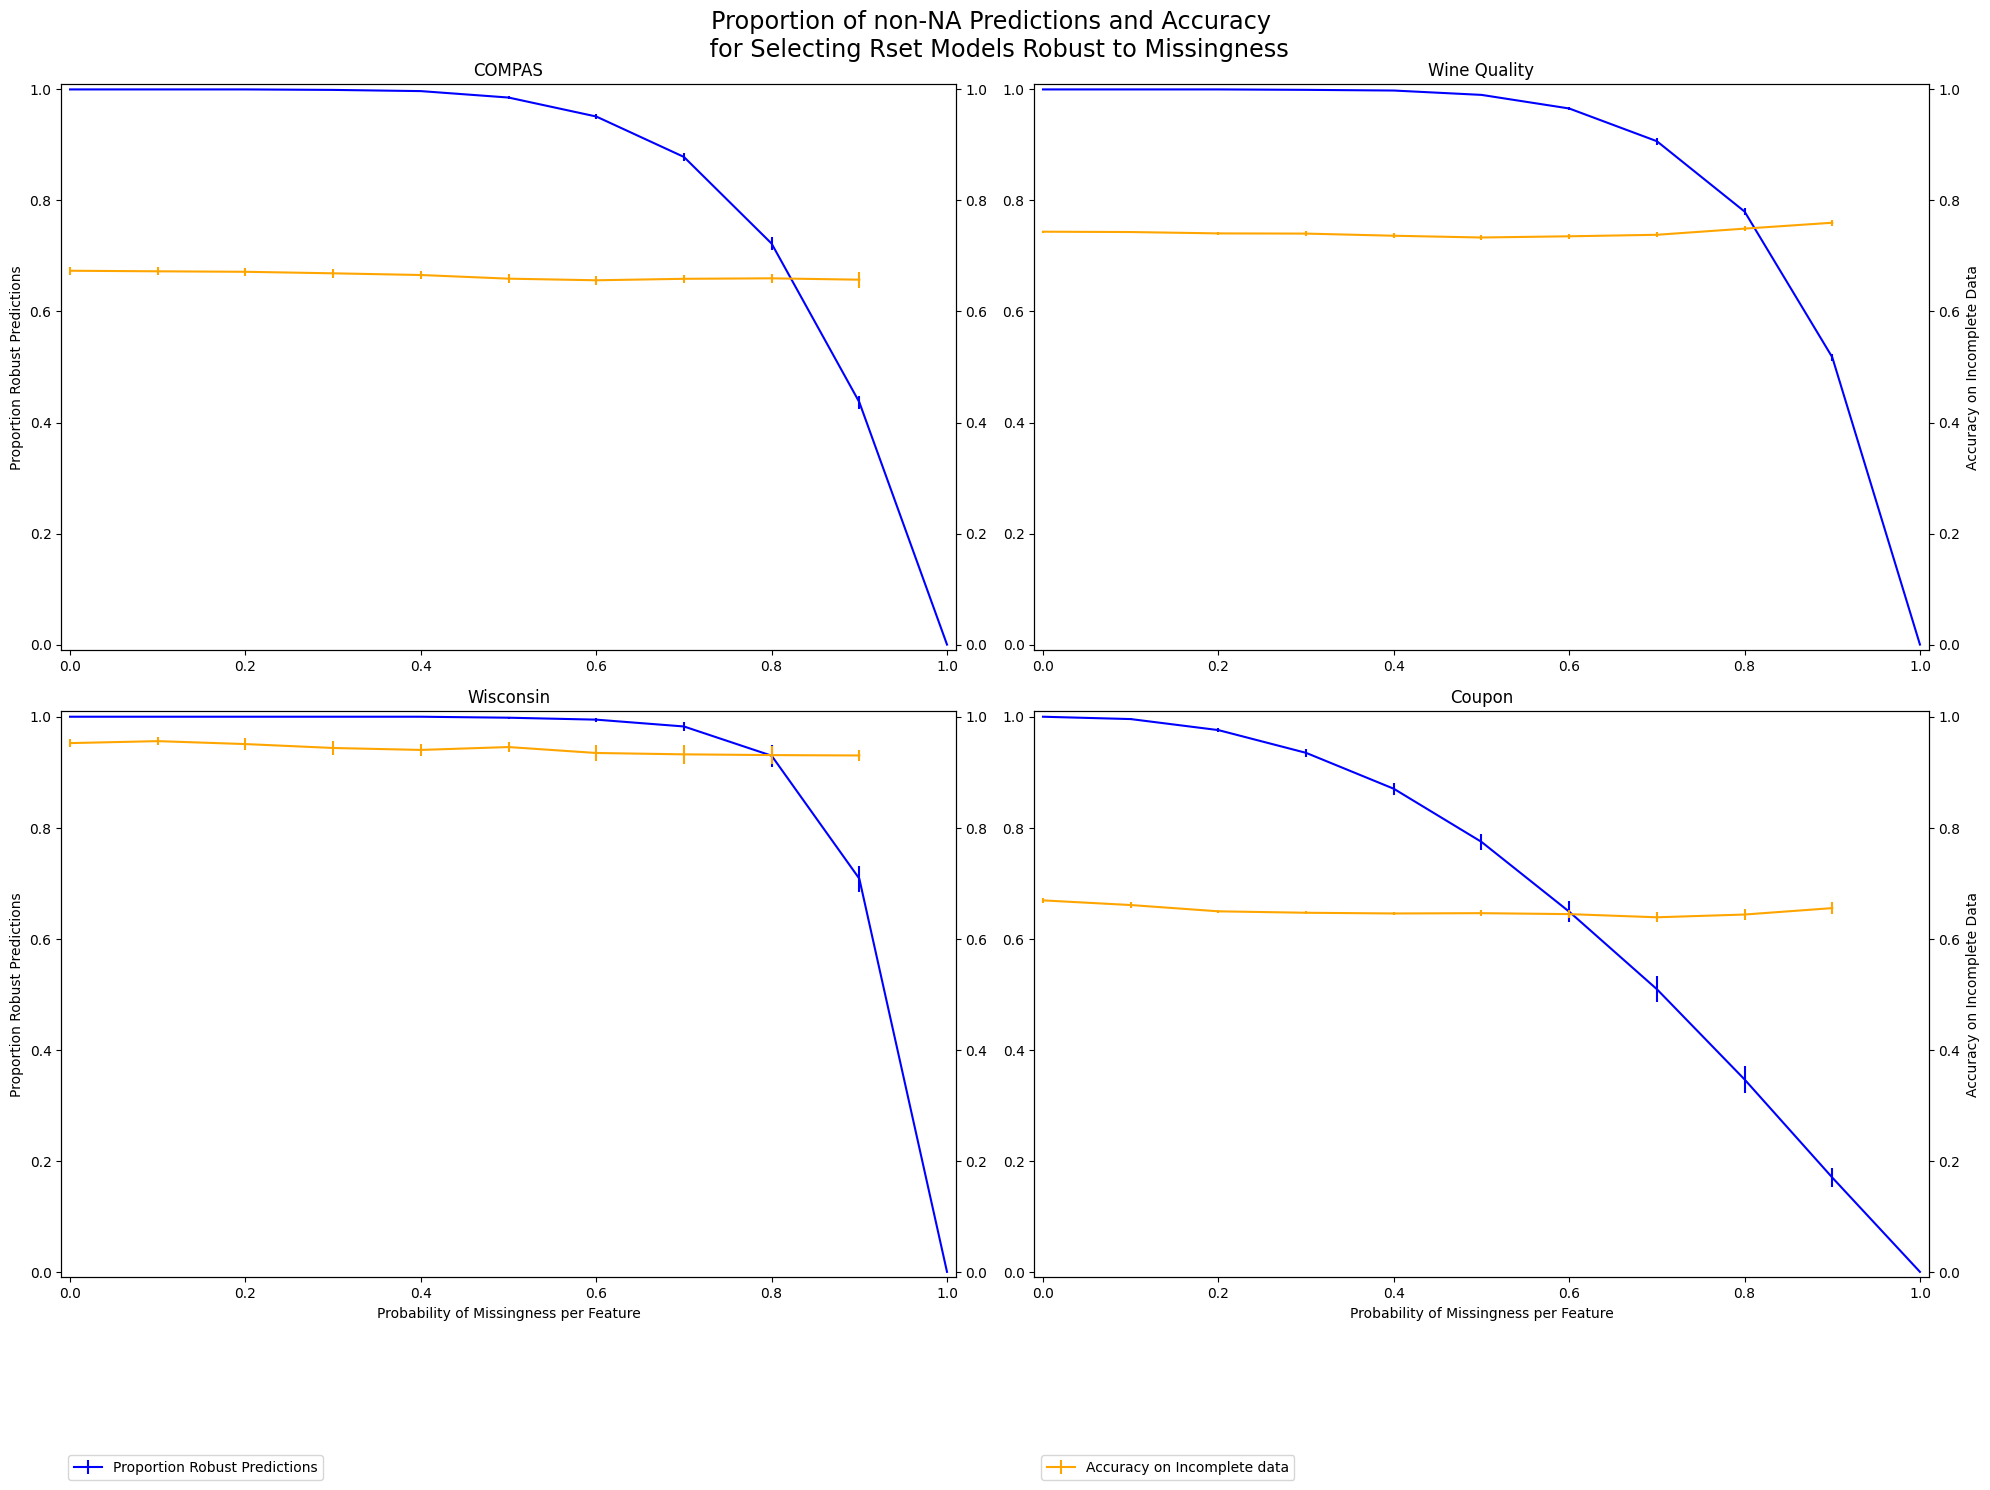

In [11]:
datasets = ['compas_complete.csv', 'wine_quality.csv', 'wisconsin.csv', 'coupon_full.csv']

fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs = axs.flatten()
fig.suptitle('Proportion of non-NA Predictions and Accuracy \n for Selecting Rset Models Robust to Missingness', fontsize='xx-large')

for i, dataset in enumerate(datasets):    
    ys = []
    yerrs = []
    ys_proportion = []
    yerrs_proportion = []
    xs = []
    xerrs = []
    for miss_prob in miss_probs: 
        row = to_plot.loc[('rset', dataset, 'path-based', miss_prob, False, False), :]
        ys.append(row['acc_incomplete_when_not_nan']['mean'])
        yerrs.append(row['acc_incomplete_when_not_nan']['std'] / np.sqrt(5))
        ys_proportion.append(1 - row['proportion_nan']['mean'])
        yerrs_proportion.append(row['proportion_nan']['std'] / np.sqrt(5))
        xs.append(1 - row['proportion_nan']['mean'])
        xerrs.append(row['proportion_nan']['std'] / np.sqrt(5))
    axs[i].errorbar([0]+miss_probs+[1], [1]+ys_proportion+[0], yerr=[0]+yerrs_proportion+[0], label='Proportion Robust Predictions', color='blue')
    # axs[i].errorbar([0, 1], [1 - row['acc_complete_test']['mean'] + epsilon + lam * row['avg_sparsity_complete']['mean']] * 2, color='gray', linestyle='dashed', label=f"Epsilon above best tree's objective \n on complete data")
    axs[i].set_xlim(-0.01, 1.01)
    if i > 1: 
        axs[i].set_xlabel('Probability of Missingness per Feature')
    # if i %2 == 0: 
    axs[i].set_ylabel('Proportion Robust Predictions')
    axs[i].set_title(f'{printable_dataset_names[dataset]}')
    axs[i].set_ylim(-0.01, 1.01)
    ax2 = axs[i].twinx()
    ys = [row['acc_complete_test']['mean']] + ys
    yerrs = [row['acc_complete_test']['std']/np.sqrt(5)] + yerrs
    ax2.errorbar([0]+miss_probs, ys, yerr=yerrs, label='Accuracy on Incomplete data', color='orange')
    if i % 2 == 1: 
        axs[i].set_ylabel('')
        ax2.set_ylabel('Accuracy on Incomplete Data')#+sparsity')
    ax2.set_ylim(-0.01, 1.01)
    if i == 2: 
        axs[i].legend(loc='lower left', bbox_to_anchor=(0, -.37), bbox_transform=axs[i].transAxes)
    if i == 3: 
        ax2.legend(loc='lower left', bbox_to_anchor=(0, -.37), bbox_transform=axs[i].transAxes)

fig.tight_layout()
plt.savefig('plots/rsetacc.pdf')
plt.show()


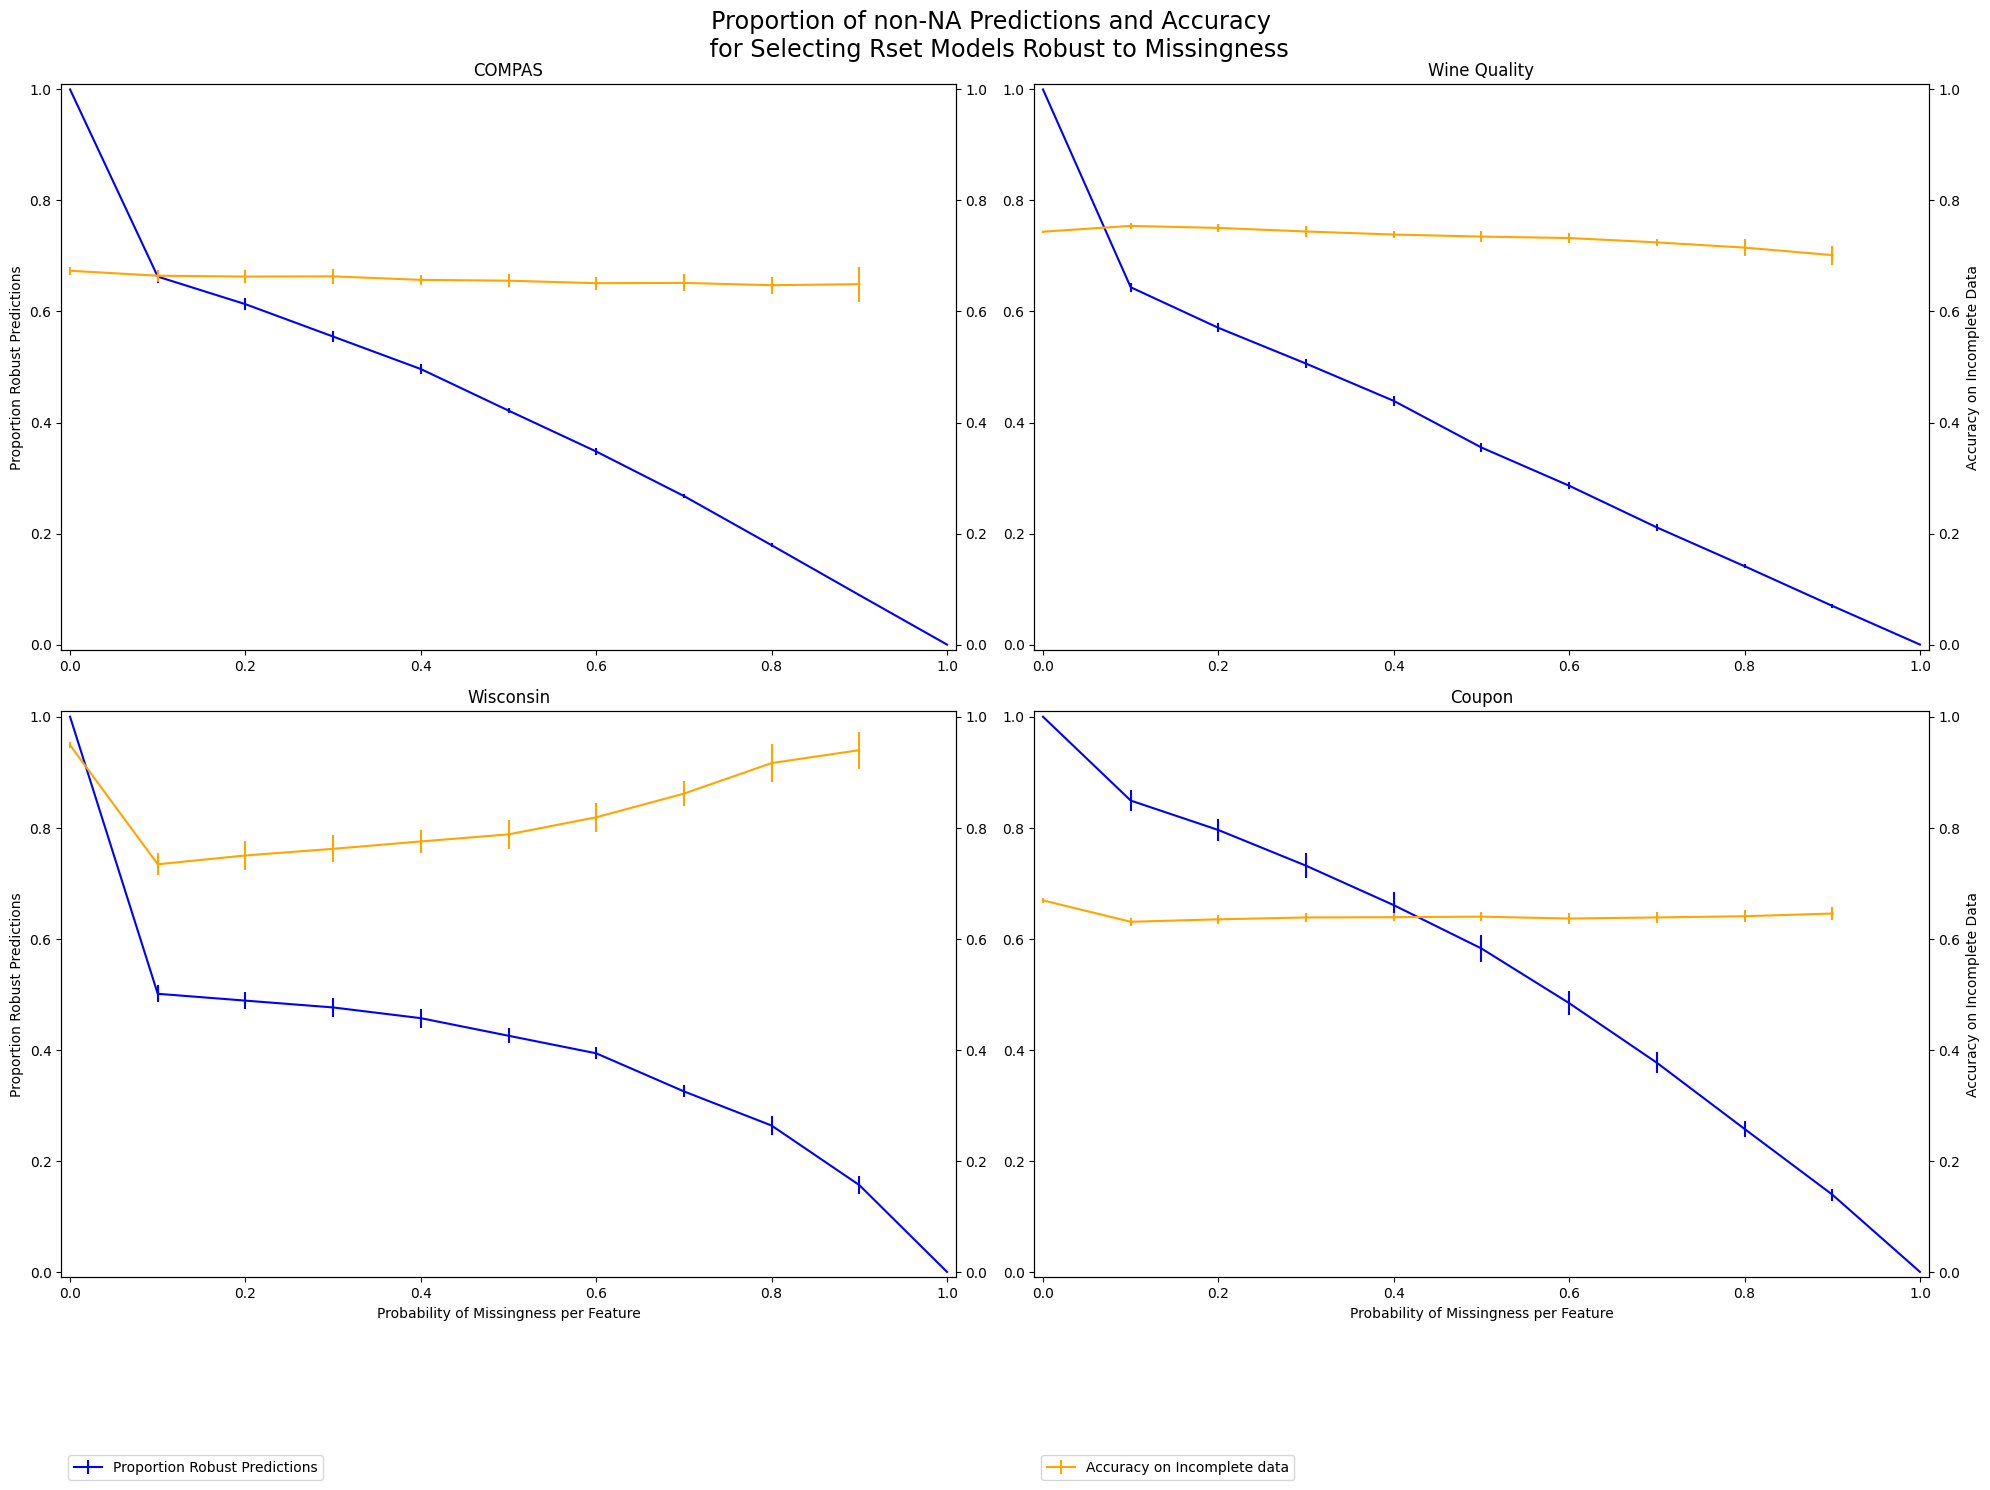

In [12]:
datasets = ['compas_complete.csv', 'wine_quality.csv', 'wisconsin.csv', 'coupon_full.csv']

fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs = axs.flatten()
fig.suptitle('Proportion of non-NA Predictions and Accuracy \n for Selecting Rset Models Robust to Missingness', fontsize='xx-large')

for i, dataset in enumerate(datasets):    
    ys = []
    yerrs = []
    ys_proportion = []
    yerrs_proportion = []
    xs = []
    xerrs = []
    for miss_prob in miss_probs: 
        row = to_plot.loc[('rset', dataset, 'path-based', miss_prob, False, True), :]
        ys.append(row['acc_incomplete_when_not_nan']['mean'])
        yerrs.append(row['acc_incomplete_when_not_nan']['std'] / np.sqrt(5))
        ys_proportion.append(1 - row['proportion_nan']['mean'])
        yerrs_proportion.append(row['proportion_nan']['std'] / np.sqrt(5))
        xs.append(1 - row['proportion_nan']['mean'])
        xerrs.append(row['proportion_nan']['std'] / np.sqrt(5))
    axs[i].errorbar([0]+miss_probs+[1], [1]+ys_proportion+[0], yerr=[0]+yerrs_proportion+[0], label='Proportion Robust Predictions', color='blue')
    # axs[i].errorbar([0, 1], [1 - row['acc_complete_test']['mean'] + epsilon + lam * row['avg_sparsity_complete']['mean']] * 2, color='gray', linestyle='dashed', label=f"Epsilon above best tree's objective \n on complete data")
    axs[i].set_xlim(-0.01, 1.01)
    if i > 1: 
        axs[i].set_xlabel('Probability of Missingness per Feature')
    # if i %2 == 0: 
    axs[i].set_ylabel('Proportion Robust Predictions')
    axs[i].set_title(f'{printable_dataset_names[dataset]}')
    axs[i].set_ylim(-0.01, 1.01)
    ax2 = axs[i].twinx()
    ys = [row['acc_complete_test']['mean']] + ys
    yerrs = [row['acc_complete_test']['std']/np.sqrt(5)] + yerrs
    ax2.errorbar([0]+miss_probs, ys, yerr=yerrs, label='Accuracy on Incomplete data', color='orange')
    if i % 2 == 1: 
        axs[i].set_ylabel('')
        ax2.set_ylabel('Accuracy on Incomplete Data')#+sparsity')
    ax2.set_ylim(-0.01, 1.01)
    if i == 2: 
        axs[i].legend(loc='lower left', bbox_to_anchor=(0, -.37), bbox_transform=axs[i].transAxes)
    if i == 3: 
        ax2.legend(loc='lower left', bbox_to_anchor=(0, -.37), bbox_transform=axs[i].transAxes)

fig.tight_layout()
plt.savefig('plots/rsetacc_prebin.pdf')
plt.show()


In [13]:
printable_dataset_names = {
    # 'compas_complete.csv': 'COMPAS',
    # 'wine_quality.csv': 'Wine Quality',
    # 'wisconsin.csv': 'Wisconsin',
    # 'coupon_carryout.csv': 'Coupon Carryout',
    # 'coupon_rest20.csv': 'Coupon Restaurant',
    # 'coupon_full.csv': 'Coupon',
    'fico_complete.csv': 'FICO',
    'netherlands.csv': 'Netherlands',
    'spiral.csv': 'Spiral',
    'tic-tac-toe.csv': 'Tic-Tac-Toe',
    'iris_virginica.csv': 'Iris Virginica',
    'iris_versicolor.csv': 'Iris Versicolor',
    'iris_setosa.csv': 'Iris Setosa',
    'broward_general_2y.csv': 'Broward General',
}

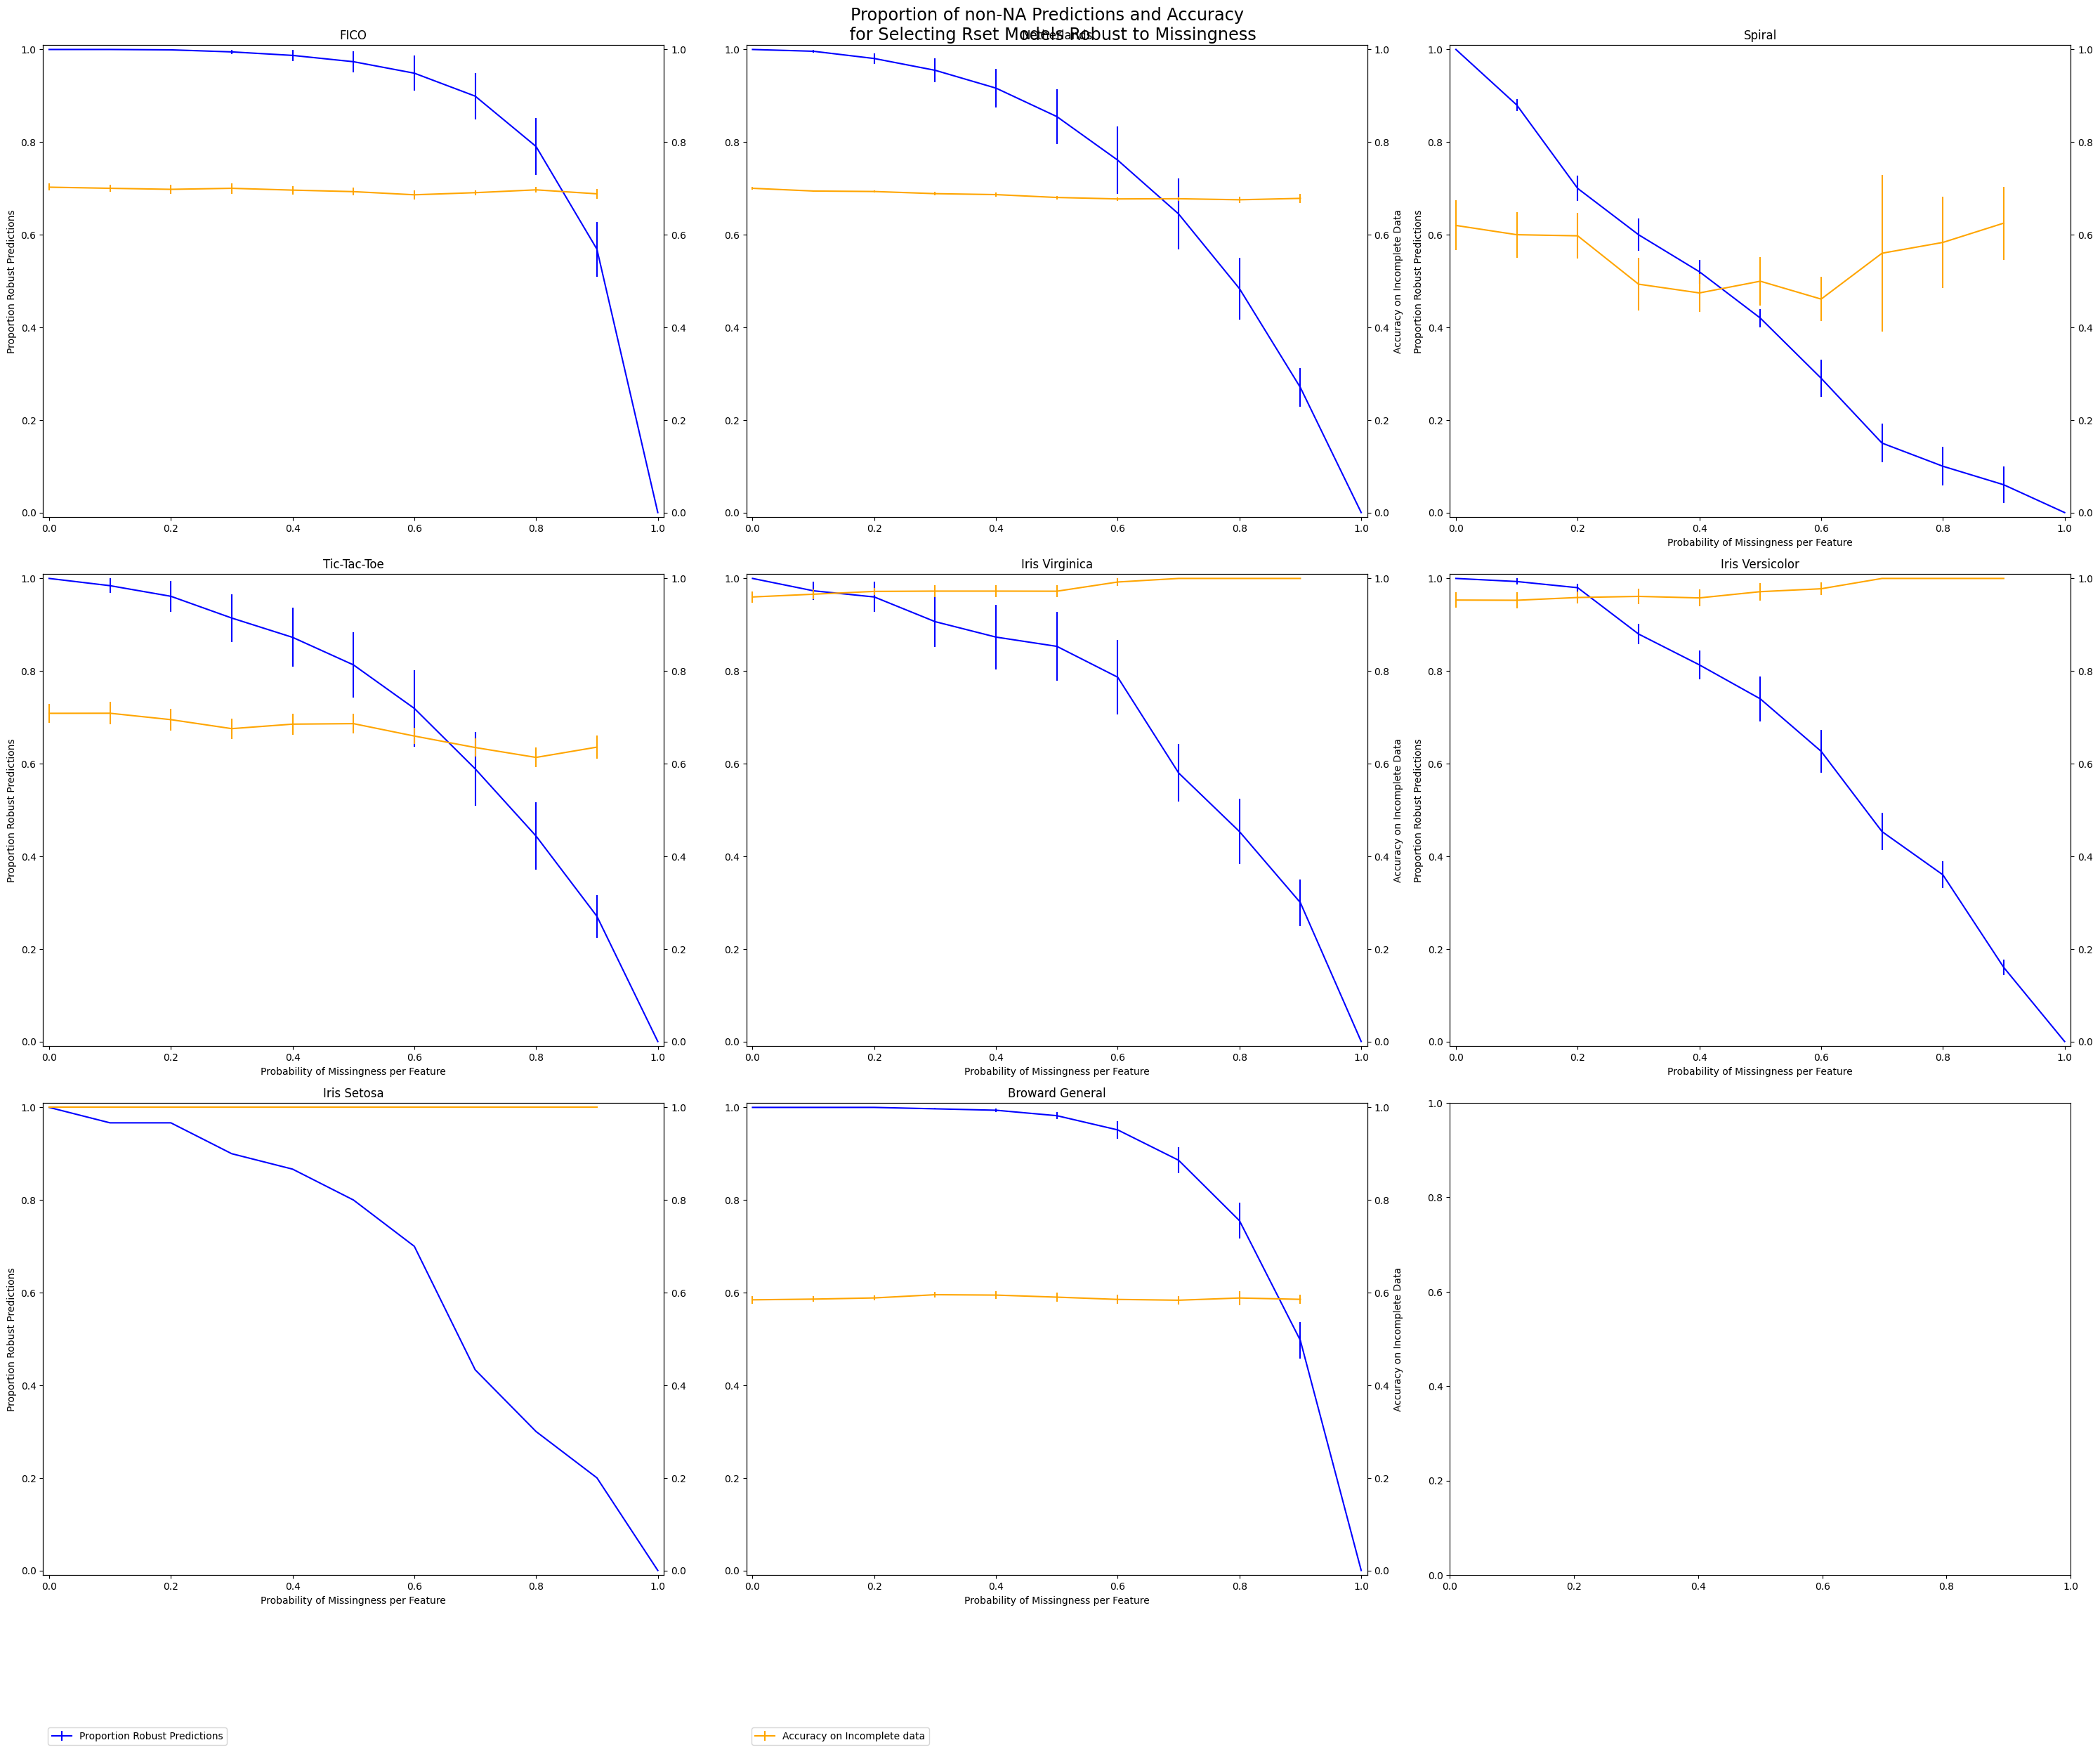

In [14]:
datasets = printable_dataset_names.keys()

fig, axs = plt.subplots(3, 3, figsize=(30, 25))
axs = axs.flatten()
fig.suptitle('Proportion of non-NA Predictions and Accuracy \n for Selecting Rset Models Robust to Missingness', fontsize='xx-large')

for i, dataset in enumerate(datasets):    
    ys = []
    yerrs = []
    ys_proportion = []
    yerrs_proportion = []
    xs = []
    xerrs = []
    for miss_prob in miss_probs: 
        row = to_plot.loc[('rset', dataset, 'path-based', miss_prob, False, False), :]
        ys.append(row['acc_incomplete_when_not_nan']['mean'])
        yerrs.append(row['acc_incomplete_when_not_nan']['std'] / np.sqrt(5))
        ys_proportion.append(1 - row['proportion_nan']['mean'])
        yerrs_proportion.append(row['proportion_nan']['std'] / np.sqrt(5))
        xs.append(1 - row['proportion_nan']['mean'])
        xerrs.append(row['proportion_nan']['std'] / np.sqrt(5))
    axs[i].errorbar([0]+miss_probs+[1], [1]+ys_proportion+[0], yerr=[0]+yerrs_proportion+[0], label='Proportion Robust Predictions', color='blue')
    # axs[i].errorbar([0, 1], [1 - row['acc_complete_test']['mean'] + epsilon + lam * row['avg_sparsity_complete']['mean']] * 2, color='gray', linestyle='dashed', label=f"Epsilon above best tree's objective \n on complete data")
    axs[i].set_xlim(-0.01, 1.01)
    if i > 1: 
        axs[i].set_xlabel('Probability of Missingness per Feature')
    # if i %2 == 0: 
    axs[i].set_ylabel('Proportion Robust Predictions')
    axs[i].set_title(f'{printable_dataset_names[dataset]}')
    axs[i].set_ylim(-0.01, 1.01)
    ax2 = axs[i].twinx()
    ys = [row['acc_complete_test']['mean']] + ys
    yerrs = [row['acc_complete_test']['std']/np.sqrt(5)] + yerrs
    ax2.errorbar([0]+miss_probs, ys, yerr=yerrs, label='Accuracy on Incomplete data', color='orange')
    if i % 3 == 1: 
        axs[i].set_ylabel('')
        ax2.set_ylabel('Accuracy on Incomplete Data')#+sparsity')
    ax2.set_ylim(-0.01, 1.01)
    if i == 6: 
        axs[i].legend(loc='lower left', bbox_to_anchor=(0, -.37), bbox_transform=axs[i].transAxes)
    if i == 7:
        ax2.legend(loc='lower left', bbox_to_anchor=(0, -.37), bbox_transform=axs[i].transAxes)

fig.tight_layout()
plt.savefig('plots/new_app_rsetacc.pdf')
plt.show()
